In [1]:
# Import libraries
%matplotlib inline

import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import pysal as ps

In [3]:
# Import data
broker_data = 'data/Brokered2018_zipcodes.csv'
coord = 'data/states.json'


In [4]:
# Read data
broker = pd.read_csv(broker_data)
broker.head()

,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,OriginState,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
0,1361713,1349039,8/15/18,1,AMNP,AMNP,43708,43708,San Antonio,Texas,Palmyra,Wisconsin,"$2,500.00","$2,400.00",$100.00,4.00%,KAILA,1
1,1501026,1542730,1/30/18,1,AMNP,AMNP,442007,442007,Hammond,Indiana,Denver,Colorado,"$3,050.00","$2,950.00",$100.00,3.27%,KAILA,1
2,1518714,1567360,1/5/18,1,AMNP,AMNP,971955,971955,Denver,Colorado,Meridian,Idaho,"$1,200.00","$1,200.00",$-,0.00%,ZABCA,2
3,1538821,1595101,4/2/18,1,AMNP,AMNP,355478,355478,Jewett,Texas,Hartford,South Dakota,"$2,000.00","$1,900.00",$100.00,5.00%,KAILA,1
4,1601007,1680031,8/22/18,1,AMNP,AMNP,184749,184749,Bismarck,North Dakota,Marion,Ohio,"$2,300.00","$2,200.00",$100.00,4.34%,KAILA,1


In [5]:
broker['Start Date'] =  pd.to_datetime(broker['Start Date'])

In [6]:
print(broker['Start Date'])

0        2018-08-15
1        2018-01-30
2        2018-01-05
3        2018-04-02
4        2018-08-22
            ...    
213739   2021-05-28
213740   2021-05-28
213741   2021-05-31
213742   2021-05-31
213743   2021-05-31
Name: Start Date, Length: 213744, dtype: datetime64[ns]


In [15]:
# Find the max date in the data set for rolling 12 month
endDate = broker['Start Date'].max()
endDate

Timestamp('2021-05-31 00:00:00')

In [16]:
# Rolling date start point
startDate = endDate - pd.DateOffset(years=1)
startDate

Timestamp('2020-05-31 00:00:00')

In [17]:
#filter out data prior to start date to have rolling 12 months; rename origin column to state
filteredBroker = broker.loc[(broker['Start Date'] >= startDate)]
filteredBroker.rename(columns = {'OriginState':'NAME'}, inplace = True)


for col in filteredBroker.columns:
    print(col)
    
filteredBroker

Order #
Leg #
Start Date
Agent Office
Cust ID
Customer
Carrier ID
Carrier
Origin City
NAME
Destination City
Destination State
Brokered Revenue
Carrier Pay
Brokered Margin
Brokered Margin %
Booking Agent ID
Booking Agent


/Users/shannagreathouse/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Order #,Leg #,Start Date,Agent Office,Cust ID,Customer,Carrier ID,Carrier,Origin City,NAME,Destination City,Destination State,Brokered Revenue,Carrier Pay,Brokered Margin,Brokered Margin %,Booking Agent ID,Booking Agent
131033,2039632,2219540,2021-04-27,1,AMNP,AMNP,155298,155298,Saint Paul,Minnesota,Bottineau,North Dakota,"$1,600.00","$1,500.00",$100.00,6.25%,HERRO,4
142166,2069107,2258289,2020-06-19,5,CONELP,CONELP,775727,775727,Heyburn,Idaho,Council Bluffs,Iowa,"$2,150.56","$1,700.00",$450.56,20.95%,MELMI,9
144595,2075503,2266726,2020-06-01,17,FAMMAU,FAMMAU,70282,70282,Rolesville,North Carolina,Cowpens,South Carolina,$521.74,$500.00,$21.74,4.16%,OCASO,104
144596,2075504,2266727,2020-06-08,17,FAMMAU,FAMMAU,70282,70282,Rolesville,North Carolina,Cowpens,South Carolina,$521.74,$500.00,$21.74,4.16%,OCASO,104
144598,2075506,2266729,2020-06-08,17,FAMMAU,FAMMAU,673535,673535,Rolesville,North Carolina,Cowpens,South Carolina,$-,$150.00,($150.00),0.00%,OCASO,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213739,2341809,2586585,2021-05-28,10,MONEAS,MONEAS,TX6877A,TX6877A,Houston,Texas,Houston,Texas,"$1,200.00","$1,000.00",$200.00,16.66%,QUITHO,39
213740,2347760,2593593,2021-05-28,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,$143.96,$-,$143.96,100.00%,UNKNOWN,6
213741,2347761,2593594,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,$143.96,$-,$143.96,100.00%,UNKNOWN,6
213742,2347762,2593595,2021-05-31,16,CHICHA,CHICHA,770152,770152,New Castle,Delaware,Wilmington,Delaware,$143.96,$-,$143.96,100.00%,UNKNOWN,6


In [18]:
# Variables maintained
varis = ['Agent Office', 'Customer', 'Booking Agent','Carrier']

In [19]:
#Group data by state
states = filteredBroker.groupby(‘NAME’)[‘varis’].count()

SyntaxError: invalid character in identifier (<ipython-input-19-b771f2e504c6>, line 2)

In [21]:
#Group by customers
types = pd.get_dummies(filteredBroker['Customer'])
region_types = types.join(filteredBroker['NAME'])\
                  .groupby('NAME')\
                  .sum()
region_types_pct = (region_types * 100.).div(region_types.sum(axis=1), axis=0)
region_types_pct.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Alabama to Wyoming
Columns: 397 entries, 3MCFOR to ZIMLYN
dtypes: float64(397)
memory usage: 149.2+ KB


In [22]:
region_props = states.join(region_types_pct)

NameError: name 'states' is not defined

In [23]:
#Scale 
db = pd.DataFrame(\
                 scale(region_props), \
                 index=region_props.index, \
                 columns=region_props.columns)\
       .rename(lambda x: str(int(x)))

NameError: name 'region_props' is not defined

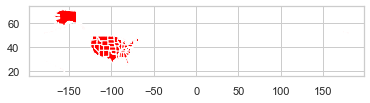

In [24]:
# bring in geojson dataframe
usMap = gpd.read_file(coord)
usMap.plot(color='red');

In [28]:
# match geojson dataframe and broker_data on 'state'
statedb = usMap[['geometry', 'STATE', 'NAME']].join(db, on='NAME')\
                                         .dropna()

NameError: name 'db' is not defined

In [29]:
#Cluster in specfic groups
km5 = cluster.KMeans(n_clusters=5)

In [30]:
# Fit to data
km5cls = km5.fit(statedb.drop(['geometry', 'NAME'], axis=1).values)

NameError: name 'statedb' is not defined

NameError: name 'statedb' is not defined

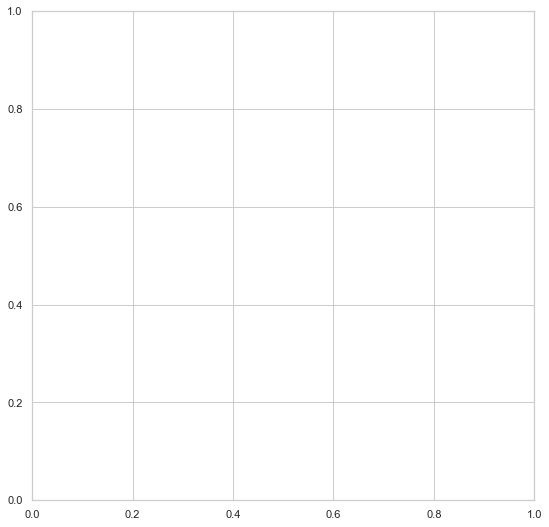

In [31]:
# Map clusters
f, ax = plt.subplots(1, figsize=(9, 9))

statedb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

In [32]:
# Attributes
cl_pcts = region_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(statedb['NAME'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .mean()

ValueError: invalid literal for int() with base 10: 'Alabama'

NameError: name 'cl_pcts' is not defined

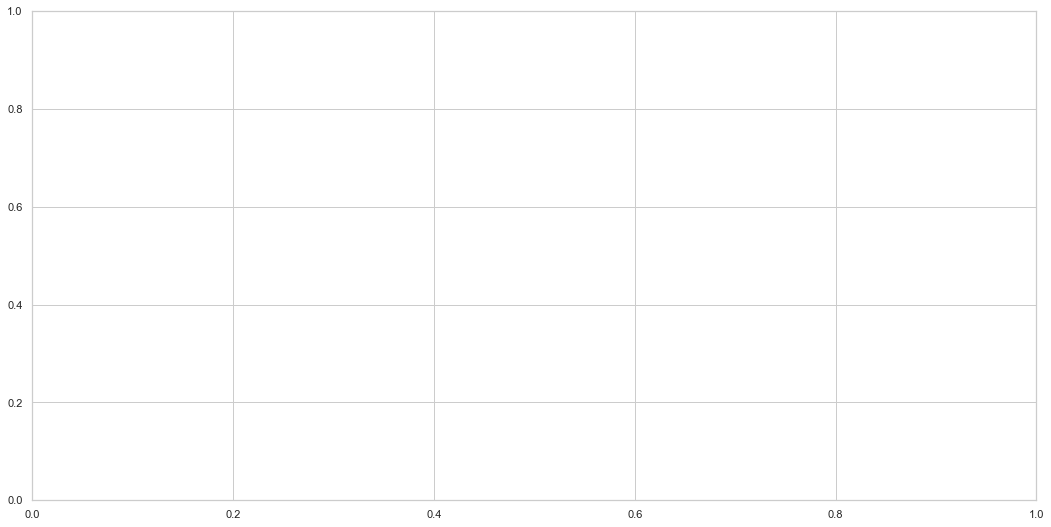

In [132]:
#Visualize attributes and mix
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");